In [28]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
LW=5 # linewidth
MS=10 # markersize

In [29]:
def generate_truth(N, x0, H, del_step, Q, R):
    """Generate the truth for the second-order system"""
    del_t = 0.01
    g = 9.8 #m/s
    xout = np.zeros((N+1, 2))  
    m = H.shape[0]
    yout = np.empty((N, 1))
    yout[:] = np.nan
    xout[0, :] = x0
    for ii in range(N):
        xout[ii+1, 0] = xout[ii, 0] + (xout[ii, 1]*del_t)
        xout[ii+1, 1] = xout[ii, 1] - (g * np.sin(xout[ii,0]) * del_t)
        q_k = np.dot(np.linalg.cholesky(Q), np.random.randn(2))
        xout[ii+1, :] = xout[ii+1, :] + q_k
    
    for ii in range(0, N, del_step):
        r_delk = np.sqrt(R)*np.random.randn(1)
        yout[ii] = np.sin(xout[ii, 0]) + r_delk
        
    return xout, yout

In [30]:
x_init = [1.5, 0]
del_t = 0.01
del_step = 5
R = 1
q_c = 0.1
N_steps = 500
H = np.eye(2)
Q_cov = [[(q_c*(del_t**3))/3, (q_c*(del_t**2))/2], [(q_c*(del_t**2))/2, (q_c*del_t)]]
print(Q_cov)
xout, yout = generate_truth(N_steps, x_init, H, del_step, Q_cov, R)
print(xout.shape)
print(yout.shape)

[[3.333333333333334e-08, 5e-06], [5e-06, 0.001]]
(501, 2)
(500, 1)


In [31]:
DT = 1
T = 500
Nsims = int(T / DT)
t = np.linspace(0, T, Nsims+1)

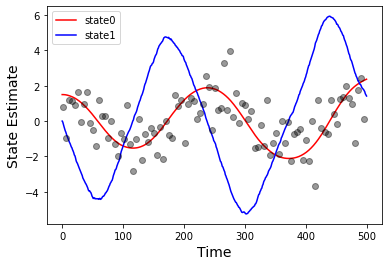

In [32]:
plt.figure()
plt.plot(t, xout[:, 0], color='red', label='state0')
plt.plot(t, xout[:, 1], color='blue', label='state1')
plt.plot(t[1:], yout[:, 0], 'ko', alpha=0.4)
#plt.plot(t[1:], yout[:, 1], 'kx', alpha=0.4)
plt.legend()
plt.xlabel('Time', fontsize=14)
plt.ylabel('State Estimate',fontsize=14)
plt.show()

In [33]:
def ekf_update_step(data, H, H_T, mean, cov, noise_cov):
    
    mu = np.sin(mean[0])
    delta = data - mu
    S = np.dot(H, np.dot(cov, H_T)) + noise_cov
    U = np.dot(cov, H_T)
   
    update_mean = mean.reshape(2,1) + (U*delta/S).reshape(2,1)
    update_mean = update_mean.reshape(2,)

    update_cov = cov - np.dot(U, (U.T)/S)
    return update_mean, update_cov

In [34]:
def ekf_prediction_step(A, A_T, mean, cov, noise_cov):
    
    pred_mean = np.zeros((2,1))
    del_t = 0.01
    g = 9.8
    pred_mean[0] = mean[0] + (mean[1]*del_t)
    pred_mean[1] = mean[1] - (g*np.sin(mean[0])*del_t)
    pred_mean = np.reshape(pred_mean,(2,))
    pred_cov = np.dot(A, np.dot(cov, A_T)) + noise_cov
    return pred_mean, pred_cov

In [35]:
def extended_kalman_filter(data, prior_mean, prior_cov, R):
  
    del_t = 0.01
    g = 9.8 #m/s
    qc = 0.1
    d = prior_mean.shape[0]
    N = data.shape[0]
    m = data.shape[1]
    
    mean_store = np.zeros((N+1, d))
    mean_store[0, :] = np.copy(prior_mean)
    cov_store = np.zeros((d, d, N+1))
    cov_store[:, :, 0] = np.copy(prior_cov)
    Q = [[(qc*(del_t**3))/3, (qc*(del_t**2))/2], [(qc*(del_t**2))/2, (qc*del_t)]]
    #R = 1
    
    #Loop over all data
    for ii in range(N):
        # Prediction
        A_k = np.array([[1, del_t], [-g*np.cos(mean_store[ii, 0])*del_t, 1]])
        A_k_trans = A_k.T
        #print(A_k.T)
        H_k =np.array([[np.cos(mean_store[ii, 0]) ,0]])
        #print(H_k)
        H_k_trans = H_k.T
        pred_mean, pred_cov = ekf_prediction_step(A_k, A_k_trans, mean_store[ii, :], cov_store[:, :, ii], Q)
         # Update

        if not np.isnan(data[ii]):
            mean_store[ii+1, :], cov_store[:, :, ii+1] = ekf_update_step(data[ii, :], H_k, H_k_trans, pred_mean, pred_cov, R)
        else:
            mean_store[ii+1, :] = pred_mean
            cov_store[:, :, ii+1] = pred_cov

    return mean_store, cov_store

In [36]:
def get_std(cov):
    """Get square root of diagonals (standard deviations) from covariances """
    
    d, d, N = cov.shape
    std_devs = np.zeros((N, d))
    for ii in range(N):
        std_devs[ii, :] = np.sqrt(np.diag(cov[:, :, ii]))
    return std_devs

In [37]:
data = yout
R = 1
prior_mean = np.array([1.5, 0])
print(prior_mean)
prior_cov = np.eye(2)
print(prior_cov.shape)

mean_ekf, cov_ekf = extended_kalman_filter(data, prior_mean, prior_cov, R)

[1.5 0. ]
(2, 2)


In [38]:
K = 5 # time discretization error, only use a model that integrates at 5 times larger time step (and observes more rarely)
DTsim = 1
#Asim = DTsim * Asim + np.eye(2)
T = 500
Nsims_sim = int(T / DTsim)
tsim = np.linspace(0, T, Nsims_sim+1)
# yuse = yout[np.arange(K-1, yout.shape[0], K), :]

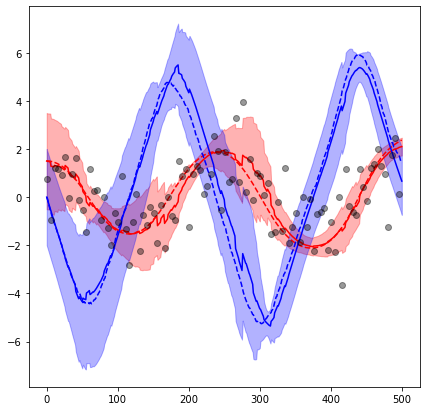

In [39]:
std_devs = get_std(cov_ekf) #extract the standard deviations at all the states
plt.figure(figsize=(7,7))
plt.plot(t, xout[:, 0],'--', color='red', label='state0truth')
plt.plot(t, xout[:, 1],'--', color='blue', label='state1truth')

plt.plot(t, mean_ekf[:, 0], color='red', label='state0')
plt.plot(t, mean_ekf[:, 1], color='blue', label='state1')
plt.fill_between(t, mean_ekf[:, 0] - 2 * std_devs[:, 0],  mean_ekf[:, 0] + 2*std_devs[:, 0], color='red', alpha=0.3)
plt.fill_between(t, mean_ekf[:, 1] - 2 * std_devs[:, 1],  mean_ekf[:, 1] + 2*std_devs[:, 1], color='blue', alpha=0.3)
plt.plot(t[1:], yout[:], 'ko', alpha=0.4)
# #plt.plot(t[1:], yout[:, 1], 'kx', alpha=0.4)
# #plt.plot(tsim[1:], yuse[:, 0], 'ko', alpha=0.4)
# #plt.plot(tsim[1:], yuse[:, 1], 'kx', alpha=0.4)
# plt.legend()
# plt.xlabel('Time', fontsize=14)
# plt.ylabel('State Estimate',fontsize=14)
# plt.show()

Time Elapsed for Extended Kalman Filter with R = 1.0, delta = 5 0.015621662139892578
Mean squared error for state 1= 0.01047236529255327
Mean squared error for state 2= 0.0
Time Elapsed for Extended Kalman Filter with R = 1.0, delta = 10 0.0
Mean squared error for state 1= 0.012755623576003444
Mean squared error for state 2= 0.0
Time Elapsed for Extended Kalman Filter with R = 1.0, delta = 20 0.0
Mean squared error for state 1= 0.005156982866565686
Mean squared error for state 2= 0.0
Time Elapsed for Extended Kalman Filter with R = 1.0, delta = 40 0.015627145767211914
Mean squared error for state 1= 0.0038847408434432578
Mean squared error for state 2= 0.0
Time Elapsed for Extended Kalman Filter with R = 0.1, delta = 5 0.0
Mean squared error for state 1= 0.0033897958086123114
Mean squared error for state 2= 0.0
Time Elapsed for Extended Kalman Filter with R = 0.1, delta = 10 0.015619516372680664
Mean squared error for state 1= 0.09430869465130533
Mean squared error for state 2= 0.0
Tim

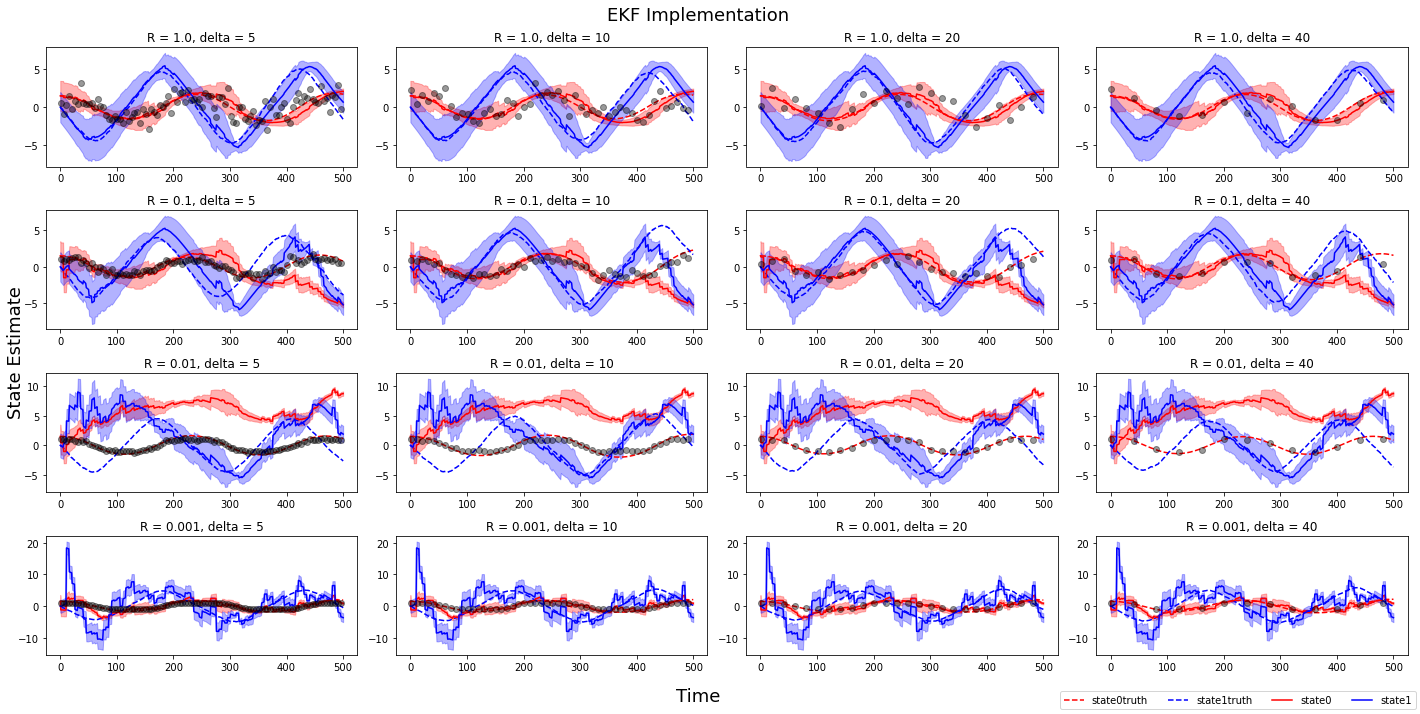

In [41]:
N = 500
x_init = np.array([1.5, 0])
g = 9.8 #m/s
prior_cov = np.eye(2)
R_set = np.array([1, 0.1, 0.01, 0.001])
delta_set = np.array([5, 10, 20, 40])
fig, subplt = plt.subplots(4, 4, figsize = (20,10))

for ii in range(4):
    R = R_set[ii]
    for jj in range(4):
        del_step = delta_set[jj]
        tsim = np.linspace(0, T, N+1)
        
        xout, yout = generate_truth(N_steps, x_init, H, del_step, Q_cov, R) 
        start_time = time.time()
        mean_EKF, cov_EKF = extended_kalman_filter(data, x_init, prior_cov, R)
        
        print("Time Elapsed for Extended Kalman Filter with R = " + str(R) + ", delta = " + str(del_step), time.time() - start_time)
        
        for kk in range(0, xout.shape[0]):
            sq_err_s0 = np.zeros((xout.shape[0],1))
            sq_err_s1 = np.zeros((xout.shape[0],1))
            sq_err_s0[kk,:] = (xout[kk,0] - mean_EKF[kk,0])**2
            sq_err_s0[kk,:] = (xout[kk,1] - mean_EKF[kk,1])**2
        mean_sq_err_s0 = np.mean(sq_err_s0)
        print('Mean squared error for state 1=', mean_sq_err_s0)
        
        mean_sq_err_s1 = np.mean(sq_err_s1)
        print('Mean squared error for state 2=', mean_sq_err_s1)
        
        std_devs = get_std(cov_ekf)
        ax = subplt[ii,jj]
        ax.plot(t, xout[:, 0],'--', color='red', label='state0truth')
        ax.plot(t, xout[:, 1],'--', color='blue', label='state1truth')
        ax.plot(tsim, mean_EKF[:, 0], color='red', label='state0')
        ax.plot(tsim, mean_EKF[:, 1], color='blue', label='state1')
        ax.plot(t[1:], yout[:], 'ko', alpha=0.4)
        ax.fill_between(t, mean_EKF[:, 0] - 2 * std_devs[:, 0],  mean_EKF[:, 0] + 2*std_devs[:, 0], color='red', alpha=0.3)
        ax.fill_between(t, mean_EKF[:, 1] - 2 * std_devs[:, 1],  mean_EKF[:, 1] + 2*std_devs[:, 1], color='blue', alpha=0.3)
        ax.set_title("R = " + str(R) + ", delta = " + str(del_step))
fig.suptitle('EKF Implementation', fontsize = 18)
fig.supxlabel('Time', fontsize = 18)
fig.supylabel('State Estimate', fontsize = 18)
fig.legend(["state0truth", "state1truth", "state0", "state1"], loc = 'lower right', ncol = 5, bbox_transform = fig.transFigure)
fig.tight_layout()
plt.show()